<a href="https://colab.research.google.com/github/sznajder/Notebooks/blob/master/AE_AnomalyDetectio_TFKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AE with a arhcitecture similar to the VAE in v 7.1

In [ ]:
VAEversion='0'

In [ ]:
from glob import glob
import os, sys, scipy, pickle
from scipy.stats import chi2, poisson
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

from prettytable import PrettyTable

In [ ]:
import ROOT as rt
import root_numpy as rtnp
from utility_func import *

/Users/olmo/programs/root-6.10.08/lib/ROOT.py:318: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _orig_ihook( name, *args, **kwds )
Using TensorFlow backend.


In [ ]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import layers as KL
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, ModelCheckpoint
from keras.constraints import max_norm
import keras
print keras.__version__

2.1.2


In [ ]:
do_training = 1

# Get the samples

In [ ]:
hlf_features = ['HT', 'METp', 'METo', 'MT', 'nJets', 
                'bJets', 'allJetMass', 'LepPt', 'LepEta', 
                'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 
                'LepIsEle', 'nMu', 'allMuMass', 'allMuPt', 'nEle', 
                'allEleMass', 'allElePt', 'nChHad', 'nNeuHad', 'nPhoton']

active_hlf_features = ['HT', 'allJetMass',
                       'allMuPt', 'allMuMass',
                       'allElePt','allEleMass',
                       'LepPt', 'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu',
                       
                       'METp', 'METo',
                       
                       'MT',
                       
                       'nMu', 'nJets', 'bJets', 'nEle', 
                       
                       'LepCharge','LepIsEle', 
                       
                       'nChHad', 'nNeuHad']

Nf_lognorm = 10
Nf_gauss = 2
Nf_Pgauss = 1
Nf_PDgauss = 4
Nf_binomial = 2
Nf_poisson = 2

sel = []
for a in active_hlf_features:
    for i,f in enumerate(hlf_features):
        if a == f:
            sel.append(i)
# print 'Activated HLF:'
# for n in np.array(hlf_features)[sel]:
#     print '\t', n

In [ ]:
data_folder = '../data/HLF_ONLY/'
TrainSamplesName = ['Wlnu', 'qcd', 'Zll', 'ttbar']
BSM_samples = ['Ato4l', 'Zprime', 'Wprime', 'leptoquark', 'hToTauTau', 'hChToTauNu']

N_train_max = int(9e6)
training_split_fraction = 0.5

In [ ]:
fraction = np.array([0.592, 0.338, 0.067, 0.003])

raw_sample = {}
l = np.zeros(4)
for i,n in enumerate(TrainSamplesName):
    raw_sample[n] = np.load(data_folder+n+'_sample.npy')
#     np.random.shuffle(raw_sample[n])
    l[i] = raw_sample[n].shape[0]
    
i_min = np.argmin(l/fraction)
if TrainSamplesName[i_min]=='qcd':
    print 'QCD is limiting, using it for both val and split'
    N_train = min(N_train_max, l[i_min]/fraction[i_min])
else:
    N_train = min(N_train_max, training_split_fraction*l[i_min]/fraction[i_min])

if N_train < N_train_max:
    print 'Limiting stat. sample:', TrainSamplesName[i_min]
else:
    print 'Sample available satisfying '

N_val = N_train*(1-training_split_fraction)/training_split_fraction - 1
print 'Expected {:.2f}M train'.format(N_train/1.0e6)
print 'Expected {:.2f}M val'.format(N_val/1.0e6)

QCD is limiting, using it for both val and split
Limiting stat. sample: qcd
Expected 3.45M train
Expected 3.45M val


In [ ]:
x_train_s = {}
x_val_s = {}

table = PrettyTable(['Sample', 'Evts tot', 'Train', 'Val'])

for i,n in enumerate(TrainSamplesName):
    N_train_aux = int(N_train * fraction[i])
    x_train_s[n] = raw_sample[n][:N_train_aux, sel]
    N_val_aux = int(N_val * fraction[i])
    if TrainSamplesName[i_min]=='qcd' and n == 'qcd':
        print 'QCD is limiting, using it for both val and split'
        np.random.shuffle(raw_sample[n])
        x_val_s[n] = raw_sample[n][:N_val_aux, sel]
    elif N_train_aux+N_val_aux < raw_sample[n].shape[0]:
        x_val_s[n] = raw_sample[n][N_train_aux : N_train_aux+N_val_aux, sel]
    else:
        print 'Error', n
        continue
    table.add_row([n, raw_sample[n].shape[0], x_train_s[n].shape[0], x_val_s[n].shape[0]])
print table
    
x_train = np.concatenate((x_train_s['Wlnu'], x_train_s['qcd'], x_train_s['Zll'], x_train_s['ttbar']))
x_val = np.concatenate((x_val_s['Wlnu'], x_val_s['qcd'], x_val_s['Zll'], x_val_s['ttbar']))

print 'Tot training {:.2f} M'.format(x_train.shape[0]/1.0e6)
print 'Tot val {:.2f} M'.format(x_val.shape[0]/1.0e6)

QCD is limiting, using it for both val and split
+--------+----------+---------+---------+
| Sample | Evts tot |  Train  |   Val   |
+--------+----------+---------+---------+
|  Wlnu  | 8000082  | 2042566 | 2042565 |
|  qcd   | 1166195  | 1166195 | 1166194 |
|  Zll   | 1777383  |  231168 |  231168 |
| ttbar  | 5001726  |  10350  |  10350  |
+--------+----------+---------+---------+
Tot training 3.45 M
Tot val 3.45 M


# Start the VAE declaration

In [ ]:
original_dim = x_train.shape[1]
latent_dim = 4
intermediate_dim = 50
kernel_max_norm = 1000.
act_fun = 'relu'

In [ ]:
x_DNN_input = Input(shape=(original_dim,), name='Input')
hidden_1 = Dense(intermediate_dim, activation=act_fun, name='Encoder_h1')
aux = hidden_1(x_DNN_input)
hidden_2 = Dense(intermediate_dim, activation=act_fun, kernel_constraint=max_norm(kernel_max_norm), name='Encoder_h2')
aux = hidden_2(aux)

L_z_latent = Dense(latent_dim, name='Latent')
T_z_latent = L_z_latent(aux)

In [ ]:
decoder_h1 = Dense(intermediate_dim, 
                   activation=act_fun, 
                   kernel_constraint=max_norm(kernel_max_norm), 
                   name='Decoder_h1')(T_z_latent)

decoder_h2 = Dense(intermediate_dim, activation=act_fun, name='Decoder_h2')(decoder_h1)

x_output = Dense(original_dim, name='Output')(decoder_h2)

In [ ]:
vae = Model(inputs=x_DNN_input, outputs=x_output)

vae.compile(optimizer='adam', 
            loss='MSE'
            )

print vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 21)                0         
_________________________________________________________________
Encoder_h1 (Dense)           (None, 50)                1100      
_________________________________________________________________
Encoder_h2 (Dense)           (None, 50)                2550      
_________________________________________________________________
Latent (Dense)               (None, 4)                 204       
_________________________________________________________________
Decoder_h1 (Dense)           (None, 50)                250       
_________________________________________________________________
Decoder_h2 (Dense)           (None, 50)                2550      
_________________________________________________________________
Output (Dense)               (None, 21)                1071      
Total para

# Training

In [ ]:
if do_training:    
    fit_report = vae.fit(x=x_train, y=x_train,
            validation_data = (x_val, x_val),
            shuffle=True,
            epochs=400,
            batch_size=1000,
            callbacks = [
                            EarlyStopping(monitor='val_loss', patience=20, verbose=1, min_delta=0.005),
                            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, epsilon=0.01, verbose=1),
                            TerminateOnNaN()
                ])

Train on 3450279 samples, validate on 3450277 samples
Epoch 1/400
3450279/3450279 [==============================] - 20s 6us/step - loss: 101.5323 - val_loss: 54.8225
Epoch 2/400
3450279/3450279 [==============================] - 21s 6us/step - loss: 51.4724 - val_loss: 48.9311
Epoch 3/400
3450279/3450279 [==============================] - 20s 6us/step - loss: 44.1150 - val_loss: 41.1823
Epoch 4/400
3450279/3450279 [==============================] - 20s 6us/step - loss: 40.1805 - val_loss: 38.5868
Epoch 5/400
3450279/3450279 [==============================] - 19s 6us/step - loss: 38.4227 - val_loss: 37.8433
Epoch 6/400
3450279/3450279 [==============================] - 19s 6us/step - loss: 37.2289 - val_loss: 36.5888
Epoch 7/400
3450279/3450279 [==============================] - 20s 6us/step - loss: 36.1736 - val_loss: 36.2806
Epoch 8/400
3450279/3450279 [==============================] - 19s 6us/step - loss: 35.1511 - val_loss: 34.9874
Epoch 9/400
3450279/3450279 [====================

Epoch 72/400
3450279/3450279 [==============================] - 19s 6us/step - loss: 25.4737 - val_loss: 25.5091
Epoch 73/400
3450279/3450279 [==============================] - 19s 6us/step - loss: 25.4233 - val_loss: 25.4807
Epoch 74/400
3450279/3450279 [==============================] - 19s 6us/step - loss: 25.4641 - val_loss: 25.5125
Epoch 75/400
3450279/3450279 [==============================] - 20s 6us/step - loss: 25.4302 - val_loss: 25.4939
Epoch 76/400
3450279/3450279 [==============================] - 19s 6us/step - loss: 25.4219 - val_loss: 25.5113
Epoch 77/400
3450279/3450279 [==============================] - 19s 6us/step - loss: 25.3888 - val_loss: 25.4623
Epoch 78/400
3450279/3450279 [==============================] - 19s 6us/step - loss: 25.3872 - val_loss: 25.4145
Epoch 79/400
3450279/3450279 [==============================] - 19s 6us/step - loss: 25.3926 - val_loss: 25.4993
Epoch 80/400
3450279/3450279 [==============================] - 19s 6us/step - loss: 25.3707 - v

2019-02-06 13:34:25.351474: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


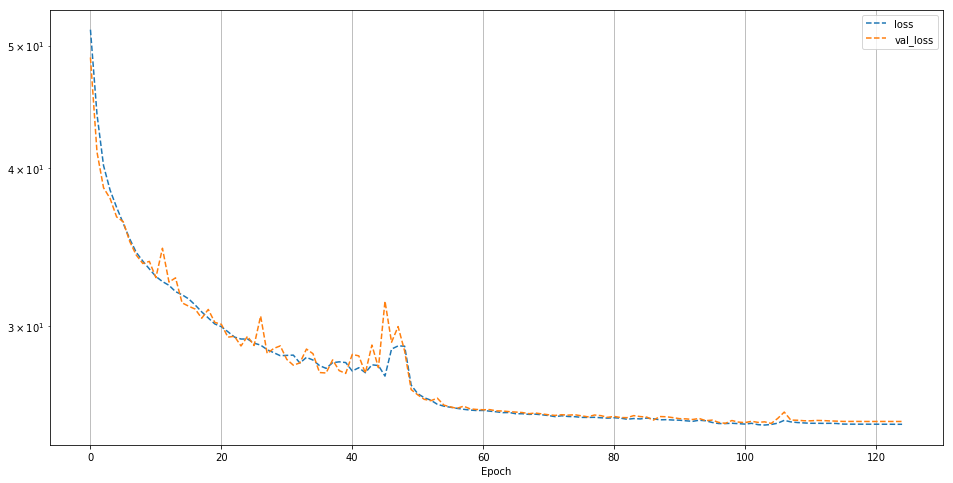

In [ ]:
if do_training:
    f = plt.figure(figsize=(16,8))
    style = {'loss':'--'}
    for item in style.keys():
        plt.plot(fit_report.history[item][1:], style[item], label=item)
        plt.plot(fit_report.history['val_'+item][1:], style[item], label='val_'+item)

    plt.xlabel('Epoch')
    plt.grid()
    plt.legend(loc='best')
    plt.yscale('log')
    f.savefig('plots/TrainingHistory_VAE_all-in-one_v'+VAEversion+'.png')
    
    f = open('TrainingHistory_VAE_all-in-one_v'+VAEversion+'.pkl', 'w')
    pickle.dump(fit_report.history, f, pickle.HIGHEST_PROTOCOL)
    f.close()

In [ ]:
if do_training:
    vae.save('AE_all-in-one_v'+VAEversion+'.h5')
else:
    from keras.models import load_model
    custom_objects = {
        'original_dim': x_train.shape[1],
        'latent_dim': latent_dim,
        'intermediate_dim': intermediate_dim,
        'act_fun': act_fun,
    }
    
    vae = load_model('AE_all-in-one_v'+VAEversion+'.h5', custom_objects=custom_objects)
    print 'Loaded'

### Build encoder and decoder

Get prior means and variance array

In [ ]:
if do_training:
    encoder = Model(inputs=x_DNN_input, outputs=T_z_latent)
    encoder.save('encoder_all-in-one_v'+VAEversion+'.h5')
else:
    encoder = load_model('encoder_all-in-one_v'+VAEversion+'.h5', custom_objects=custom_objects)

In [ ]:
autoencoder = vae

# Validation

Gather the signal data

In [ ]:
x_sig = {}
for n in BSM_samples+TrainSamplesName:
    s = np.load(data_folder+n+'_sample.npy')
    x_sig[n] = s[:N_train_max, sel]

### Predict latent space

In [ ]:
x_val_encoded = np.array(encoder.predict(x_val, batch_size=2000))

x_sig_encoded = {}
for k,v in x_sig.iteritems():
    x_sig_encoded[k] = np.array(encoder.predict(v, batch_size=2000))

Latent space mean distribution

In [ ]:
histos = []
canvases = []
N_bins = 100
rt.gStyle.SetOptTitle(0)

for kk in range(latent_dim):
    print 'Plotting dim', kk, '...'
    canvas = rt.TCanvas('c'+str(kk), 'c'+str(kk), 600, 400)
    canvas.SetLeftMargin(0.16)
    canvas.SetBottomMargin(0.16)
    canvas.SetRightMargin(0.02)
    canvas.SetTopMargin(0.02)

    l_bound = mu_prior[kk] - 6*sigma_prior[kk]
    u_bound = mu_prior[kk] + 6*sigma_prior[kk]
    bin_width = (u_bound - l_bound)/N_bins
    z = np.arange(l_bound, u_bound, bin_width)
    
    bin_content = sum_of_gaussians(z, x_val_encoded[0, :, kk], x_val_encoded[1, :, kk])*bin_width
    print '\t SMMix coverage: {:.3f}'.format(np.sum(bin_content))
    h = rt.TH1F('h_SMMix_{}'.format(kk), 'SMMix', N_bins, l_bound-bin_width/2., u_bound+bin_width/2.)
    for i,c in enumerate(bin_content): 
        h.SetBinContent(i+1, c)
    h.GetYaxis().SetRangeUser(1e-5, 0.9)
    h.SetStats(0)
    h.SetLineWidth(0)
    h.SetFillColorAlpha(rt.kGreen+2, 0.7)
    h.SetFillStyle(3001)
    
    h.SetXTitle('z_{'+str(kk)+'}')
    h.GetXaxis().SetTitleSize(0.06)
    h.GetXaxis().SetLabelSize(0.06)
    h.SetYTitle('p.d.f.')
    h.GetYaxis().SetTitleSize(0.06)
    h.GetYaxis().SetTitleOffset(1.16)
    h.GetYaxis().SetLabelSize(0.06)    
    
    h.Draw('Bar')
    histos.append(h)


    colors = [1,2,4,rt.kYellow+2,6,7,8,46, 30, 40]
    # fill
    for i, n in enumerate(x_sig.keys()):
        bin_content = sum_of_gaussians(z, x_sig_encoded[n][0, :, kk], x_sig_encoded[n][1, :, kk])*bin_width
        print '\t {} coverage: {:.3f}'.format(n, np.sum(bin_content))
        h = rt.TH1F('h_{}_{}'.format(n, kk), n, N_bins, l_bound-bin_width/2., u_bound+bin_width/2.)
        for j,c in enumerate(bin_content): 
            h.SetBinContent(j+1, c)

        h.SetStats(0)
        h.SetLineColor(colors[i])
        h.SetLineWidth(2)
        h.Draw('SAME')
        histos.append(h)
    leg = canvas.BuildLegend(0.8, 0.6, 0.99, 0.99, '','lf')
        
    line = rt.TLine()
    line.SetLineWidth(2)
    line.SetLineStyle(9)
    line.SetLineColor(9)
    l = line.DrawLine(mu_prior[kk], 1e-5, mu_prior[kk], 0.9)
    leg.AddEntry(l, 'Prior Mean', 'l')
    line.SetLineColor(40)
    l = line.DrawLine(mu_prior[kk]-sigma_prior[kk], 1e-5, mu_prior[kk]-sigma_prior[kk], 0.9)
    leg.AddEntry(l, 'Prior Sigma', 'l')
    
    line.DrawLine(mu_prior[kk]+sigma_prior[kk], 1e-5, mu_prior[kk]+sigma_prior[kk], 0.9)
    
    canvas.SetGrid()
    canvas.SetLogy()
    canvas.Draw()
    canvas.Update()
    canvases.append(canvas)
    
fout = rt.TFile('plots/all-in-one_v'+VAEversion+'_Zpdf.root', 'RECREATE')
for obj in canvases + histos:
    obj.Write()

fout.Close()

## Recostruction sum of pdf

In [ ]:
out_ae_val = autoencoder.predict(x_val, batch_size=2000)

In [ ]:
f, ax_arr = plt.subplots(int(len(active_hlf_features)/3.),3 , figsize=(18,36))
N_bins = 100
for i,hlf_name in enumerate(active_hlf_features):
    print hlf_name
    
    #Plot distribution of the variable
    x_aux = x_val[:, i]
    if i < Nf_lognorm:
        histo_range = (0, np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        if np.sum(bin_edges>clip_x_to0) > 0:
            i_aux = np.argmin(bin_edges<clip_x_to0)
            bin_edges = np.concatenate((np.array([0, clip_x_to0]), bin_edges[i_aux:]))
        else:
            bin_edges = np.array([0, clip_x_to0])
        bin_content, bin_edges = np.histogram(x_aux, bins=bin_edges, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bin_edges[1:] - bin_edges[:-1]
        bin_width[0] = 1.

        mu_vec = pars_ae_val[0][:, i]
        sigma_vec = pars_ae_val[1][:, i]
        f_vec = pars_ae_val[2][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_lognorm(bincenters, f_vec, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss:
        histo_range = (np.percentile(x_aux, .1), np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_val[0][:, i]
        sigma_vec = pars_ae_val[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_gaussians(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss:
        histo_range = (np.percentile(x_aux, .1), np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_val[0][:, i]
        sigma_vec = pars_ae_val[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_Pgauss(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss:
        Nmax = int(np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=Nmax+1, range=(-0.5, Nmax+0.5))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_val[0][:, i]
        sigma_vec = pars_ae_val[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_PDgauss(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss + Nf_binomial:
        bin_content, bin_edges = np.histogram(x_aux, bins=2, range=(np.min(x_aux), np.max(x_aux)))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        p = 0.5*(1+0.98*np.tanh(pars_ae_val[0][:, i]))

        spdf_bin_content = np.zeros_like(bincenters)
        spdf_bin_content[np.nonzero(bin_content)[0][1]] = np.sum(p)
        spdf_bin_content[np.nonzero(bin_content)[0][0]] = np.sum(1-p)
    else:
        Nmax = int(np.percentile(x_aux, 99.5))
        bin_content, bin_edges = np.histogram(x_aux, bins=Nmax+1, range=(-0.5, Nmax+0.5))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        aux = pars_ae_val[0][:, i]
        mu_vec = 1 + np.where(np.greater(aux, 0), aux, np.divide(aux, np.sqrt(1+np.square(aux))))
        spdf_bin_content = sum_of_possion(bincenters, mu_vec)


    if i < Nf_lognorm:
        bin_width[0] = clip_x_to0
        
    ax_arr[i/3, i%3].errorbar(bincenters, bin_content, xerr=bin_width/2., yerr=np.sqrt(bin_content), fmt='.b', label='input')
    ax_arr[i/3, i%3].errorbar(bincenters, spdf_bin_content, xerr=bin_width/2., fmt='.r', label='spdf')
    ax_arr[i/3, i%3].ticklabel_format(axis='y', style='sci')
    ax_arr[i/3, i%3].grid()
    ax_arr[i/3, i%3].set_title(hlf_name + ' - SMMix')        
    ax_arr[i/3, i%3].legend(loc='best')
    
    if hlf_name.startswith('LepIso') or hlf_name.startswith('all'):
        ax_arr[i/3, i%3].set_yscale('log')
        
        
f.savefig('plots/SMMix_SumOfPdfs_v'+VAEversion+'.pdf')        
plt.show()

# Test Statistics with Losses

In [ ]:
print 'SMMix', x_train.shape
out = x_train - vae.predict(x_train, batch_size=2000)
loss_train = np.array([np.average(np.square(out), axis=1)])

loss_sig = {}
for n in x_sig.keys():
    print n, x_sig[n].shape
    out = x_sig[n] - vae.predict(x_sig[n], batch_size=2000)
    loss_sig[n] = np.array([np.average(np.square(out), axis=1)])

SMMix (3450279, 21)
hToTauTau (344917, 21)
Zll (1777383, 21)
qcd (1166195, 21)
Wlnu (8000082, 21)
hChToTauNu (339018, 21)
Wprime (605662, 21)
Ato4l (652070, 21)
leptoquark (583043, 21)
Zprime (55362, 21)
ttbar (5001726, 21)


In [ ]:
BSM_labels = {'Ato4l':r'$A\to 4\ell$', 
              'leptoquark':r'$LQ$', 
              'hToTauTau':r'$h^{0}\to \tau\tau$', 
              'hChToTauNu':r'$h^{\pm}\to \tau\nu$'}

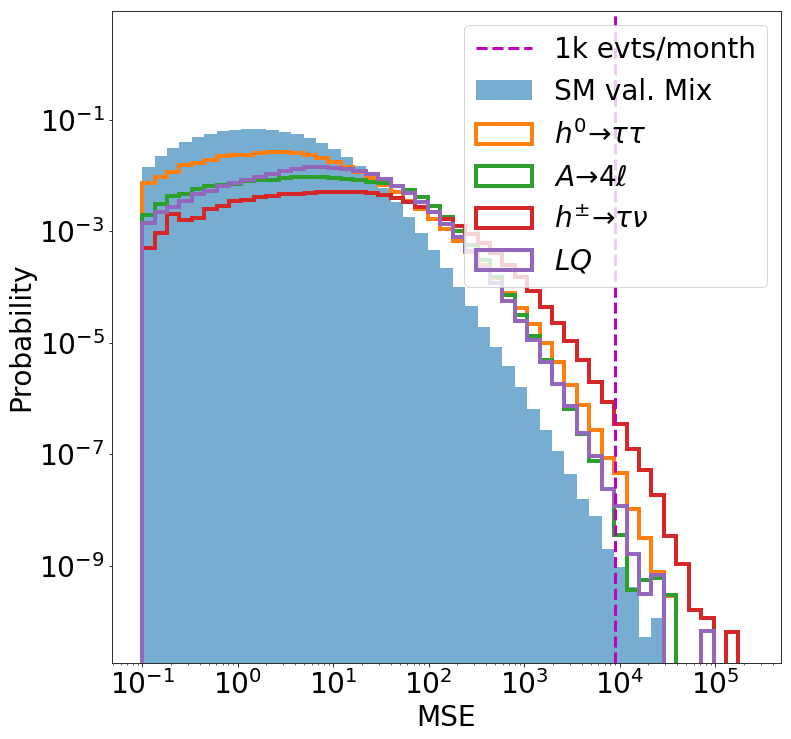

In [ ]:
matplotlib.rcParams.update({'font.size': 28})
histos = []
canvases = []
x_axis_titles = ['MSE', '$Loss_{reco}$', '$D_{KL}$']

eff_SMMix = 5.38E-06

f, ax_arr = plt.subplots(1, 1, figsize=(12, 12))

for loss_piece in range(1):
    up_end = 10*np.max(loss_train[loss_piece])
    dwn_end = max(1e-1, np.min(loss_train[loss_piece]))
    bins = np.logspace(start=np.log10(dwn_end), stop=np.log10(up_end), num=50)
    
    i_ax = loss_piece-1
    ax_arr.hist(loss_train[loss_piece], bins=bins, normed=True, label='SM val. Mix', alpha=0.6)
    
    for n, loss in loss_sig.iteritems():
        if n in BSM_labels.keys():
            ax_arr.hist(loss[loss_piece], 
                              bins=bins, normed=True, 
                              histtype='step',
                              lw=4,
                              label=BSM_labels[n])
            
    ax_arr.set_yscale('log')
    ax_arr.set_xscale('log')
    ax_arr.set_xlabel(x_axis_titles[loss_piece])
    ax_arr.set_ylabel('Probability')
    ax_arr.set_ylim(ax_arr.set_ylim()[0], 9)
    
    q = np.percentile(loss_train[loss_piece], 100*(1-eff_SMMix))
    ys = list(ax_arr.set_ylim())
    ax_arr.plot([q, q], ys, lw = 3, color='m', ls='--', label='1k evts/month')
    
    ax_arr.legend(loc='best')
    
f.subplots_adjust(wspace=0.2)
f.savefig('../fig/paper_fig/LossesPDF_AE_v'+VAEversion+'.png', bbox_inches='tight')

In [ ]:
SM_evts_per_month = 1000
SM_tot_xsec = 37.205e6 #fb

lumi_per_yr = 40 #fb^-1
DataColl_month = 8.

eff_SMMix = SM_evts_per_month/(SM_tot_xsec * lumi_per_yr/DataColl_month)
print 'Ideal Eff SM --->> {:.2e}\n\n\n'.format(eff_SMMix)

for ll in range(1):
    cut = np.percentile(loss_train[ll], 100*(1-eff_SMMix))
    
    print '----------------',Ytitles[ll], '----------------'
    table_SM = PrettyTable(['Sample', 'VAE Eff','Events fraction', 'evts/month'])
    table_BSM = PrettyTable(['Sample', 'VAE Eff', 'xsec (100 evts/month) [fb]', 'xsec (S/B = 0.3) [fb]'])
    
    N_SM_imp = 0
    dN_SM_imp = 0
    effSM_imp = 0
    deffSM_imp = 0
    for n, lss in loss_sig.items():
        if n in TrainSamplesName:
            aux = np.greater(lss[ll,:], cut)
            selected = np.sum(aux)
            eff = float(selected)/lss.shape[1]
            d_eff = np.sqrt(eff*(1-eff)/lss.shape[1])

            idx = TrainSamplesName.index(n)
            
            effSM_imp += fraction[idx]*eff
            deffSM_imp += (fraction[idx]*d_eff)**2
            
            N_evts = SM_tot_xsec*fraction[idx]*eff*lumi_per_yr/DataColl_month
            d_N_evts = N_evts*d_eff/eff
            N_SM_imp += N_evts
            dN_SM_imp += d_N_evts**2
            
    dN_SM_imp = np.sqrt(dN_SM_imp)
    deffSM_imp = np.sqrt(deffSM_imp)
    
    
    for n, lss in loss_sig.items():
        aux = np.greater(lss[ll,:], cut)
        selected = np.sum(aux)
        eff = float(selected)/lss.shape[1]
        d_eff = np.sqrt(eff*(1-eff)/lss.shape[1])
        
        if n in TrainSamplesName:
            idx = TrainSamplesName.index(n)
            N_evts = SM_tot_xsec*fraction[idx]*eff*lumi_per_yr/DataColl_month
            d_N_evts = N_evts*d_eff/eff
            table_SM.add_row([n,
                              '{:1.1e} +/- {:1.1e}'.format(eff, d_eff), 
                              '{:.2f} %'.format(100*float(N_evts/N_SM_imp)),
                              '{:.0f} +/- {:.0f}'.format(N_evts, d_N_evts)])
        else:
            if eff == 0:
                print n, eff
                continue
            x_sec_lim = 100. * DataColl_month/(lumi_per_yr * eff)
            x_sec_SoB = 0.3 * N_SM_imp * DataColl_month/(lumi_per_yr * eff)
            table_BSM.add_row([n, 
                               '{:1.1e} +/- {:1.1e}'.format(eff, d_eff), 
                               '{:.1f}'.format(x_sec_lim), 
                               '{:1.1e}'.format(x_sec_SoB)])


    print table_SM
    print 'Eff VAE SM: {:.2e} +/- {:.2e}'.format(effSM_imp, deffSM_imp)
    print 'Expected SM evts/month: {:.0f} +/- {:.0f}'.format(N_SM_imp , dN_SM_imp)
    print table_BSM
    print '\n\n'

Ideal Eff SM --->> 5.38e-06



---------------- MSE ----------------
Zprime 0.0
+--------+---------------------+-----------------+------------+
| Sample |       VAE Eff       | Events fraction | evts/month |
+--------+---------------------+-----------------+------------+
|  Zll   | 1.3e-05 +/- 2.7e-06 |     12.30 %     | 161 +/- 34 |
|  Wlnu  | 4.9e-06 +/- 7.8e-07 |     40.96 %     | 537 +/- 86 |
|  qcd   | 8.6e-07 +/- 8.6e-07 |      4.11 %     | 54 +/- 54  |
| ttbar  | 1.0e-03 +/- 1.4e-05 |     42.63 %     | 559 +/- 8  |
+--------+---------------------+-----------------+------------+
Eff VAE SM: 7.05e-06 +/- 5.76e-07
Expected SM evts/month: 1311 +/- 107
+------------+---------------------+----------------------------+-----------------------+
|   Sample   |       VAE Eff       | xsec (100 evts/month) [fb] | xsec (S/B = 0.3) [fb] |
+------------+---------------------+----------------------------+-----------------------+
| hToTauTau  | 2.0e-04 +/- 2.4e-05 |          101446.2          |  

## ROC Curves

In [ ]:
print i_min

1


In [ ]:
l = np.zeros(4)
for i,n in enumerate(TrainSamplesName):
    l[i] = loss_sig[n].shape[1]
    
i_min = np.argmin(l/fraction)
print 'Limiting stat. sample: {} ({:.2f}M)'.format(TrainSamplesName[i_min], l[i_min]*1e-6)

weight = []
for i,n in enumerate(TrainSamplesName):
    w = np.float128(fraction[i]/ fraction[i_min]) * np.float128(l[i_min]/l[i])
    weight.append(w)
weight

Limiting stat. sample: qcd (1.17M)


[0.2553181818052045295, 1.0, 0.13006134938893120572, 0.0020694542634415144572]

CumSum accuracy: 0.9999999999999530577


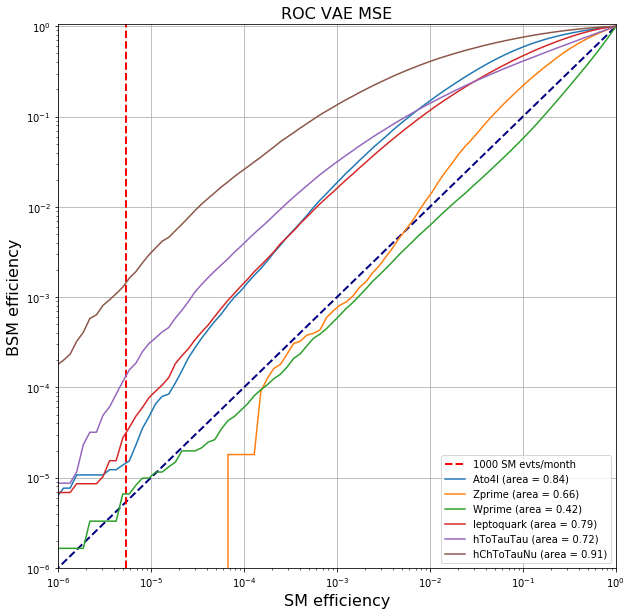

In [ ]:
p_SM = np.logspace(base=10, start=-7, stop=0, num=100)
p_SM[-1] = 0.999

for ll in range(1):
    f_ROC, ax_arr_ROC = plt.subplots(1,1, figsize=(10,10))
    ax_arr_ROC.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax_arr_ROC.plot([eff_SMMix, eff_SMMix], [1e-6, 1.05], color='red', lw=2, linestyle='--', label='1000 SM evts/month')
    ax_arr_ROC.set_xlim([1e-6, 1.0])
    ax_arr_ROC.set_ylim([1e-6, 1.05])
    ax_arr_ROC.set_xlabel('SM efficiency', fontdict={'size': 16})
    ax_arr_ROC.ticklabel_format()
    ax_arr_ROC.set_ylabel('BSM efficiency', fontdict={'size': 16})
    ax_arr_ROC.set_title('ROC VAE ' + Ytitles[ll], fontdict={'size': 16})
    ax_arr_ROC.set_yscale('log')
    ax_arr_ROC.set_xscale('log')
    ax_arr_ROC.grid()

    t_SM = np.concatenate((loss_sig['Wlnu'][ll], 
                           loss_sig['qcd'][ll],
                           loss_sig['Zll'][ll],
                           loss_sig['ttbar'][ll]
                          ))
    
    w_SM = np.concatenate((np.full_like(loss_sig['Wlnu'][ll], weight[0], np.float128),
                           np.full_like(loss_sig['qcd'][ll], weight[1], np.float128),
                           np.full_like(loss_sig['Zll'][ll], weight[2], np.float128),
                           np.full_like(loss_sig['ttbar'][ll], weight[3], np.float128)
                          ))
    
    i_sort = np.argsort(t_SM)
    
    t_SM = t_SM[i_sort]
    w_SM = w_SM[i_sort]
    
    cum_sum = np.cumsum(w_SM, dtype=np.float128)/np.float128(l[i_min]/fraction[i_min])
    print 'CumSum accuracy:', cum_sum[-1]
    
    idx_q = np.argmax(cum_sum>np.atleast_2d(1-p_SM).T, axis=1)
    q_SM = t_SM[idx_q]
    
    for n in BSM_samples:
        out = loss_sig[n][ll] > np.atleast_2d(q_SM).T
        p_BSM = np.float64(np.sum(out, axis=1, dtype=np.float128)/loss_sig[n].shape[1])
        
        roc_auc = np.trapz(p_BSM, p_SM)
        
        dic2save = {'eff_BSM':p_BSM, 'eff_SM':p_SM, 'roc_auc':roc_auc}
        fileout = open('VAE_all-in-one_v{}_ROC{}_dict_{}.pkl'.format(VAEversion, ll, n), 'w')
        pickle.dump(file=fileout, obj=dic2save)
        fileout.close()
    
        ax_arr_ROC.plot(p_SM, p_BSM, label='{} (area = {:0.2f})'.format(n, roc_auc))
        
    ax_arr_ROC.legend(loc="lower right")
    f_ROC.savefig('plots/ROC_VAE'+str(ll)+'.png')
